In [1]:
import torch
from jackpot import Jackpot

params = {
    "experiment_name": "jmlr_solar_system",
    "save_plot": True,
    "n_singular_pairs": 5,
    "max_compute_time": 3600,
    "load_sing_pairs": True,
    "save_sing_pairs": True,
    "D": 1,
    "epsilon": 1e-1,
    "n_points_per_axis": 11,
    "grid_length": 7e-9,
    "load_manifold": True,
    "save_manifold": True,
}

# ------------------------------------
#  SOLAR SYSTEM DIRECT MODEL 
# ------------------------------------

import torch.optim as optim
import torch

import matplotlib.pyplot as plt
from pathlib import Path

import deepinv as dinv
# from utils_codes.utils import neurips_mode, default_plot_styles, save_this_plot

######## IMPORT THE MODEL #################################
from article_examples.solar_system.solar_system_functions import SolarModel

import imageio.v3 as iio

from tqdm import tqdm
import os

# Device & dtype setup
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float64
factory_kwargs = {"device": device, "dtype": dtype}
torch.manual_seed(0)

/home/munier/python_envs/jackpot_env/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Plot the trajectories

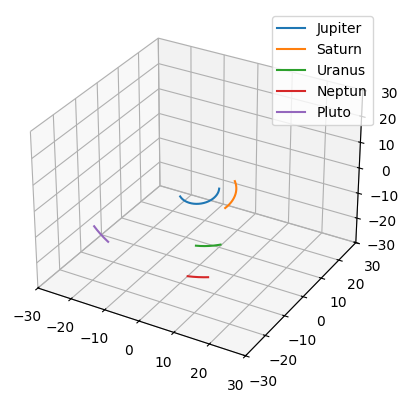

In [2]:
n_planets = 5
what_is_param = ["mass"]
dt = 7
Tinit, Tfin = 0, 365*5

solar_model = SolarModel(n_planets=n_planets, what_is_param=what_is_param,
                         solar_mass_included=False, device=device, dtype=dtype,
                         export_speed=False)

AU_to_km = 6.6846e-9
params["epsilon"] = 1000 * AU_to_km   # 1000km error

x_true = solar_model.param_default
plot_output = solar_model.plot_curves

Phi = solar_model.generate_Phi(Tinit, Tfin, dt)
plot_output(Phi(x_true), lims=30)

y_true = Phi(x_true)
y = y_true + params["epsilon"] * torch.randn_like(y_true)

### Apply Jackpot to solar system model

saves/jmlr_solar_system/jmlr_solar_system_n_5.singpairs loaded.



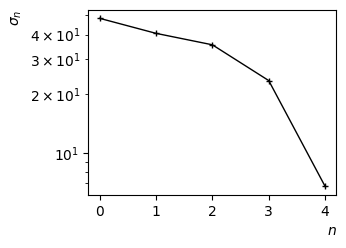

saves/jmlr_solar_system/jmlr_solar_system_d_1_eps_7e-06_n_11_l_7e-09.manifold loaded.


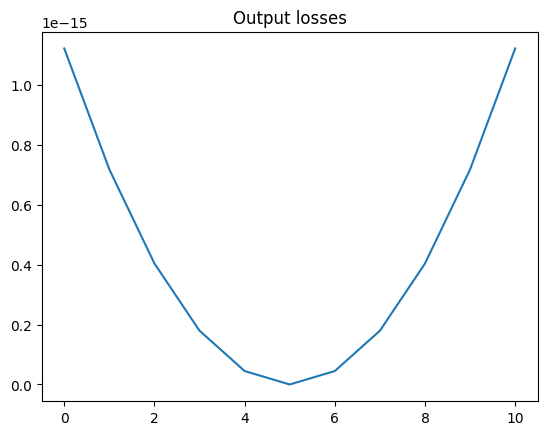

In [3]:
# %% Gradient descent to find the best parameter x0 given the data
x0 = x_true.clone().detach()
x0.requires_grad = True
niter_grad = 10

optimizer = optim.SGD([x0], lr=1e-11, momentum=0.9)

for k in range(niter_grad):
    optimizer.zero_grad()
    loss = torch.sum((Phi(x0) - y)**2)
    loss.backward()
    optimizer.step()

y0 = Phi(x0)

x_est = x0.clone().detach()
# ------------------------------------


# ------------------------------------
# JACKPOT INITIALIZATION
# ------------------------------------
jack = Jackpot(Phi, x_est)

jack.set_params(**params)
# ------------------------------------


# ------------------------------------
# JACOBIAN SINGULAR SPECTRUM
# ------------------------------------
jack.jacobian_spectrum()

# Plot spectrum
jack.jacobian_spectrum_plot()
# ------------------------------------


# ------------------------------------
# JACKPOT MANIFOLD
# ------------------------------------
jack.manifold()

# Plot discrepancy
jack.plot_discrepancy(
    in_SNR=False,
)
# ------------------------------------

In [4]:
results = jack.get_results()

### Plot the evolution of planet masses and recover that Pluto mass is uncertain

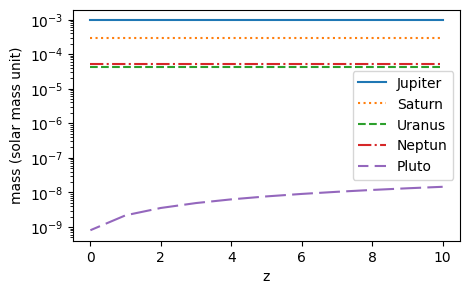

In [5]:
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (5, (10, 3))]

plt.figure(figsize=(5, 3))
for i_planet in range(5):
    mass_evol = []
    for k in range(0, 11):
        mass_evol.append(
            solar_model.mass_from_param(results[k, :])[i_planet].to("cpu"))
    plt.semilogy(range(11), mass_evol,
             color=colors[i_planet], linestyle=linestyles[i_planet])

plt.xlabel('z')
plt.ylabel('mass (solar mass unit)')
plt.legend(solar_model.planet_names)

plt.show()

### Compare with the Profile likelihood

iter:0, grad_norm:4.182e+00, loss:2.679e-02: 100%|██████████| 10/10 [01:28<00:00,  8.83s/it]


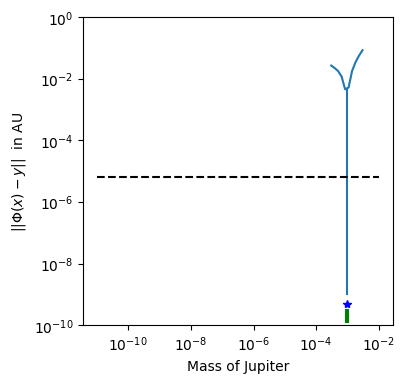

iter:0, grad_norm:2.325e-01, loss:6.758e-03: 100%|██████████| 10/10 [00:50<00:00,  5.09s/it]


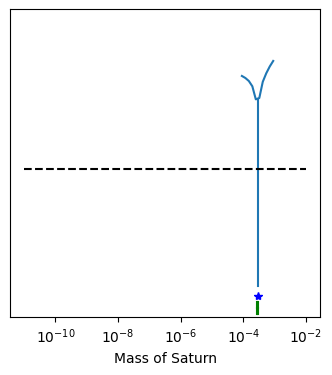

iter:0, grad_norm:1.322e-01, loss:1.082e-03: 100%|██████████| 10/10 [00:53<00:00,  5.30s/it]


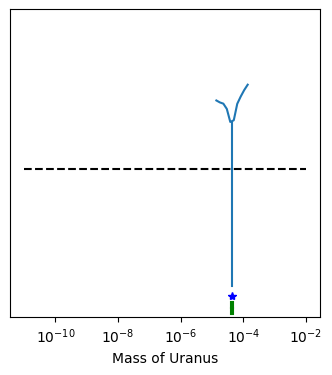

iter:0, grad_norm:7.010e-02, loss:1.054e-03: 100%|██████████| 10/10 [00:53<00:00,  5.32s/it]


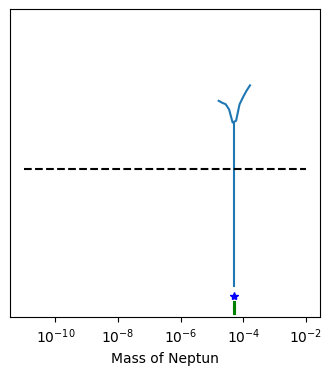

iter:0, grad_norm:1.428e-06, loss:2.814e-08:   0%|          | 0/10 [00:01<?, ?it/s]


KeyError: 'prev_loss'

In [12]:
from jackpot.prof_likelihood import *

# Define the range of values for the parameter to be profiled
load = True
n_points = 10 # 1000

for param_index in range(5):
    x_true = x_est[param_index].item()
    if param_index != 4:
        param_values = x_true * torch.logspace(-0.5, 0.5, n_points, device = device, 
                                  dtype = dtype) 
    else:
        param_values = torch.logspace(-11, -5, n_points, device = device, 
                                  dtype = dtype)
    
    # Compute the profile likelihood
    profile_likelihoods = profile_likelihood(Phi, x_est, 
                                             param_index, param_values,
                                             method = "LBFGS", lr = 1e-4,
                                             tol_change = 1e-3)
    
    # Plot the profile likelihood
    fig, ax = plt.subplots(figsize=(4,4))
    
    blue = plt.rcParams["axes.prop_cycle"].by_key()["color"][0]
    plt.loglog(param_values.tolist(), profile_likelihoods, blue)
    plt.loglog([x_true, x_true], [min(profile_likelihoods), 1e-9], blue)
    plt.xlabel(f'Mass of {solar_model.planet_names[param_index]}')
    if param_index == 0:
        plt.ylabel('$||\Phi(x) - y||$  in AU')
    else:
        ax.get_yaxis().set_visible(False)
    plt.ylim([1e-10, 1e0])
    plt.plot([x_true], [5e-10], "*b")
    plt.plot([1e-11, 1e-2], [params["epsilon"], params["epsilon"]], "--k")
   
    # Draw the confidence interval
    arg_under = torch.tensor(range(n_points))[(torch.tensor(profile_likelihoods) 
                                               < params["epsilon"])]
    if len(arg_under) < 2:
        val_min, val_max = 0.95 * x_true, 1.05 * x_true
    else:
        x_inter_min, x_inter_max = arg_under.min(), arg_under.max()
        val_min = param_values[x_inter_min].item()
        val_max = param_values[x_inter_max].item()
    
    plt.plot([val_min, val_max], 
             [2e-10, 2e-10], "-g")
    plt.plot([val_min, val_min], 
             [1.3e-10, 3e-10], "-g")
    plt.plot([val_max, val_max], 
             [1.3e-10, 3e-10], "-g")
    plt.show()